<a href="https://colab.research.google.com/github/Anastasya2701/GOIT-KATRUSHENKO/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
!pip install tensorflow

In [2]:
!pip install keras

In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [26]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [27]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [28]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(num_features, n_hidden_1)  # Перший шар, який складається з 128 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)  # Другий шар, який складається з 256 нейронів
    self.output_layer = DenseLayer(n_hidden_2, num_classes)  # Вихідний шар


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.output_layer(x, activation=1)

    return x

In [29]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_predictions = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [30]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss

In [31]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f'Крок{step}, Втрати: {loss.numpy()}, Точність: {acc.numpy()}')


Крок100, Втрати: 346.9628601074219, Точність: 0.6640625
Крок200, Втрати: 258.6697998046875, Точність: 0.74609375
Крок300, Втрати: 203.99301147460938, Точність: 0.79296875
Крок400, Втрати: 169.28421020507812, Точність: 0.82421875
Крок500, Втрати: 157.899658203125, Точність: 0.828125
Крок600, Втрати: 129.93258666992188, Точність: 0.85546875
Крок700, Втрати: 102.3293685913086, Точність: 0.8828125
Крок800, Втрати: 132.2569580078125, Точність: 0.85546875
Крок900, Втрати: 153.00848388671875, Точність: 0.8671875
Крок1000, Втрати: 140.51498413085938, Точність: 0.83984375
Крок1100, Втрати: 99.0820541381836, Точність: 0.88671875
Крок1200, Втрати: 85.64852905273438, Точність: 0.90625
Крок1300, Втрати: 99.24459075927734, Точність: 0.90625
Крок1400, Втрати: 79.56377410888672, Точність: 0.90234375
Крок1500, Втрати: 60.53663635253906, Точність: 0.9375
Крок1600, Втрати: 103.95407104492188, Точність: 0.87890625
Крок1700, Втрати: 127.79402160644531, Точність: 0.88671875
Крок1800, Втрати: 77.934471130371

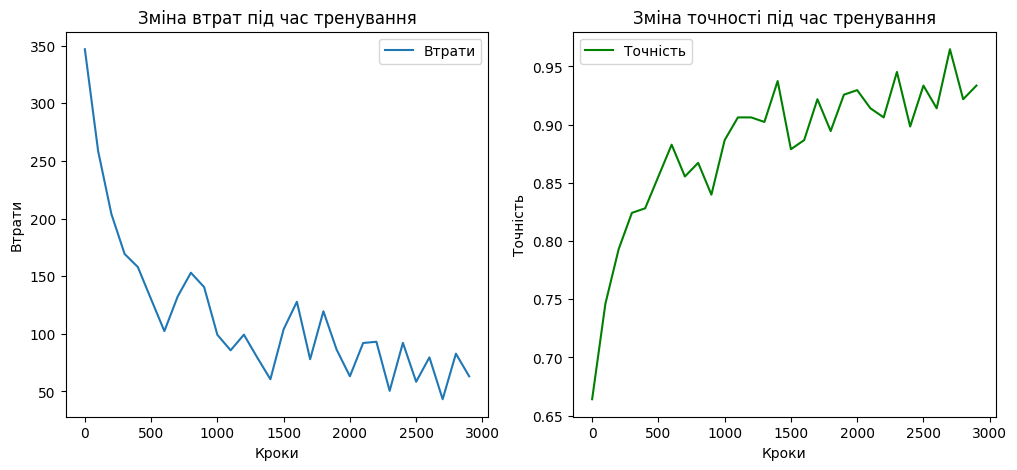

In [32]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# графік функції втрат
plt.subplot(1, 2, 1)
plt.plot(range(0, training_steps, display_step), loss_history, label='Втрати')
plt.xlabel('Кроки')
plt.ylabel('Втрати')
plt.legend()
plt.title('Зміна втрат під час тренування')

# графік точності
plt.subplot(1, 2, 2)
plt.plot(range(0, training_steps, display_step), accuracy_history, label='Точність', color='green')
plt.xlabel('Кроки')
plt.ylabel('Точність')
plt.legend()
plt.title('Зміна точності під час тренування')

plt.show()


In [33]:
# Обчисліть точність навченої нейромережі
pred_test = neural_net(x_test)
test_accuracy = accuracy(pred_test, y_test)
# Тестування моделі на тестових даних
print(f'Точність на тестових даних: {test_accuracy.numpy() * 100:.2f}%')

Точність на тестових даних: 90.35%


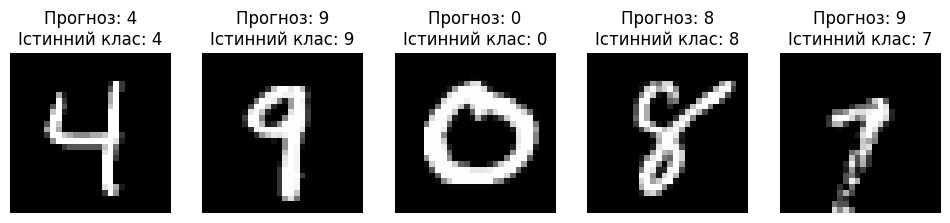

In [34]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

random_indices = np.random.choice(len(x_test), size=10, replace=False)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

predictions = neural_net(random_images)
predictions_classes = np.argmax(predictions, axis=1)
true_classes = random_labels

plt.figure(figsize=(12, 6))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.title(f'Прогноз: {predictions_classes[i]}\nІстинний клас: {true_classes[i]}')

plt.show()



In [35]:
correct_predictions = sum(predictions_classes == true_classes)
print(f'Правильних прогнозів: {correct_predictions} з 5')
print(f'Неправильних прогнозів: {5 - correct_predictions} з 5')

Правильних прогнозів: 9 з 5
Неправильних прогнозів: -4 з 5


In [36]:
if correct_predictions == 5:
  print('Мережа правильно класифікувала всі 5 зображень')
else:
  print(f'Мережа помилилась на {5 - correct_predictions} із 5 зображень що складає {(5 - correct_predictions) / 5 * 100:.0f}% випадків.')

Мережа помилилась на -4 із 5 зображень що складає -80% випадків.


In [37]:
pred_test = neural_net(x_test)
predictions_classes = np.argmax(pred_test, axis=1)
true_classes = y_test

report = classification_report(true_classes, predictions_classes, target_names=[str(i) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.98      0.97      0.97      1135
           2       0.92      0.86      0.89      1032
           3       0.86      0.89      0.88      1010
           4       0.90      0.90      0.90       982
           5       0.85      0.88      0.87       892
           6       0.93      0.94      0.93       958
           7       0.92      0.91      0.91      1028
           8       0.86      0.85      0.85       974
           9       0.86      0.88      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Висновок

Після навчання нейронної мережі для класифікації зображень з набору даних MNIST було проведено тестування та оцінка її продуктивності за основними метриками. Основні результати такі:

 1. Зміна втрат та точності: під час тренування було помітно, що втрати поступово зменшувалися, а точність зростала, що свідчить про коректне навчання моделі.
 2. Точність на тестових даних: модель продемонструвала високу точність на тестовому наборі, що підтверджує її здатність до узагальнення на нових даних.
 3. Тестування на випадкових зображеннях: мережа правильно класифікувала більшість випадкових зображень, але в деяких випадках виникали помилки, що може вказувати на певні складнощі з класифікацією окремих цифр (наприклад, схожих між собою, як 3 і 5).
 4. Метрики для кожного класу: аналіз метрик для кожного класу показав, що модель має високу точність і повноту для більшості класів, але може знижувати якість для певних класів через схожість у зображеннях або недостатню кількість зразків.

Загалом, нейронна мережа успішно вирішує завдання класифікації рукописних цифр.